In [1]:
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
from datetime import date
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
def GetPrices(stocks,period=date(2015,1,1)):
    PricesDaily = DataReader(stocks,"yahoo",period)
    PricesDaily = PricesDaily['Adj Close']
    return PricesDaily

In [3]:
stocks = ['SPY','IVV','AGG','BND','VNQ','SCHH']

In [4]:
Prices = GetPrices(stocks=stocks, period=date(2017,1,1))

In [5]:
Prices.isna().sum()

Symbols
SPY     0
IVV     0
AGG     0
BND     0
VNQ     0
SCHH    0
dtype: int64

In [6]:
Returns = np.log(Prices/Prices.shift(1))

In [7]:
Returns.dropna(inplace=True)

In [8]:
def annualize_ret(r, periods):
    compound_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compound_growth**(periods/n_periods)-1

def annualize_vol(r, periods):
    return r.std()*(periods**0.5)

In [9]:
def portfolio_return(weights, returns):
    return weights.T @ returns

def portfolio_vol(weights, covmat):
    vol = (weights.T @ covmat @ weights)**0.5
    return vol

# How did the ETFs perform over time

<AxesSubplot:xlabel='Date'>

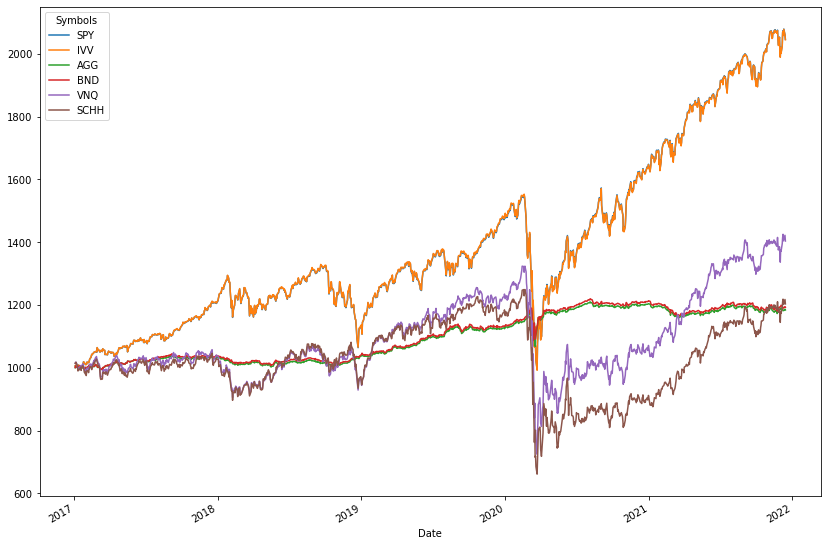

In [41]:
wealth_index = 1000*(1+Returns).cumprod()
wealth_index.plot(figsize=(14,10))

In [10]:
annual_ret = annualize_ret(Returns,periods=252)

In [11]:
covariance = Returns.cov()

In [12]:
Monthly_return_1 = Returns.resample('M').mean()

Portfolio return and vol of an equally weighted portfolio

In [14]:
weights = np.repeat(1/covariance.shape[0], covariance.shape[0])

In [15]:
portfolio_return(weights, annual_ret)*100

8.197850060148486

In [17]:
portfolio_vol(weights, covariance*252)*100

13.514997270247036

# 2 Asset Frontier

In [18]:
subset = ['SPY','AGG']
rets_1 = annual_ret[subset]
cov_1 = covariance.loc[subset,subset]*252

In [19]:
def plot_2assetfrontier(n_points, rets, cov):
    weights = [np.array([w, 1-w]) for w in np.linspace(0,1,n_points)]
    rets = [portfolio_return(w, rets) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({'Rets': rets,
                      'Vols': vols})
    return ef.plot.scatter(x='Vols', y='Rets')

In [20]:
subset = ['SPY','VNQ']
rets_1 = annual_ret[subset]
cov_1 = covariance.loc[subset,subset]*252

<AxesSubplot:xlabel='Vols', ylabel='Rets'>

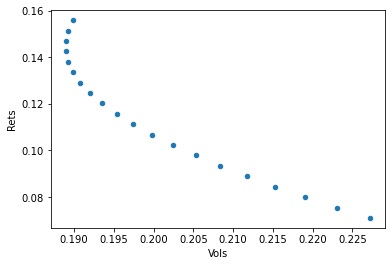

In [21]:
plot_2assetfrontier(20,rets_1,cov_1)

<AxesSubplot:xlabel='Vols', ylabel='Rets'>

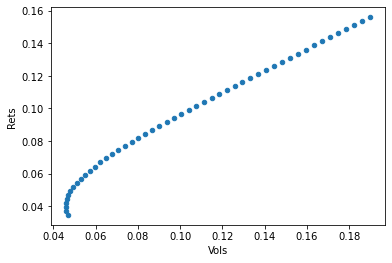

In [22]:
subset = ['SPY','AGG'] ##efficient frontier for two etf's
rets_2 = annual_ret[subset]
cov_2 = covariance.loc[subset,subset]*252
plot_2assetfrontier(50,rets_2,cov_2)

# N asset frontier

In [52]:
def optimal_weights(n_points, er, cov):
    target_rs = np.linspace(er.min(), er.max(), n_points)
    weights = [minimize_vol(target_return, er, cov) for target_return in target_rs]
    return weights

In [53]:
def plot_frontier(n_points, er, cov):
    
    weights = optimal_weights(n_points, er, cov)
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({'Rets': rets,
                      'Vols': vols})
    
    return ef.plot.scatter(x='Vols', y='Rets')

In [54]:
def minimize_vol(target_return, er, cov):
    
    n= er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),)*n
    
    weights_sum_1 = {'type': 'eq',
                    'fun': lambda weights: np.sum(weights)-1
                    }
    
    return_is_target = {'type': 'eq',
                        'args': (er,),
                       'fun': lambda weights, er: target_return - portfolio_return(weights, er) 
                       }
    
    weights = minimize(portfolio_vol, init_guess,
                      args=(cov,), method='SLSQP',
                      options={'disp':False},
                      constraints=(weights_sum_1, return_is_target),
                      bounds=bounds)
    
    return weights.x

### finding the portfolio weight giving a target return

In [37]:
rets_1

Symbols
SPY    0.155870
VNQ    0.071004
dtype: float64

In [38]:
weights_1_12per = minimize_vol(0.12, rets_1, cov_1)
weights_1_12per

array([0.57733556, 0.42266444])

In [39]:
portfolio_vol(weights_1_12per,cov_1)

0.1935845980984482

In [40]:
portfolio_return(weights_1_12per,rets_1)

0.1200000000001109

# Frontier for all ETF's quoted above

In [45]:
subset = ['SPY','IVV','AGG','BND','VNQ','SCHH']
rets_2 = annual_ret[subset]
cov_2 = covariance.loc[subset,subset]*252

<AxesSubplot:xlabel='Vols', ylabel='Rets'>

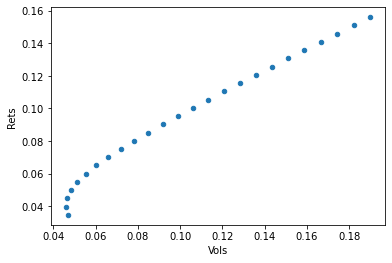

In [55]:
plot_frontier(25, rets_2, cov_2)

## test out the ret and vol at 10% target return

In [57]:
weights_2_10per = minimize_vol(0.10, rets_2, cov_2)
weights_2_10per

array([5.36281692e-01, 5.55111512e-17, 2.85409694e-01, 1.78308614e-01,
       0.00000000e+00, 0.00000000e+00])

In [58]:
portfolio_return(weights_2_10per, rets_2)

0.09999999978056182

In [59]:
portfolio_vol(weights_2_10per, cov_2)

0.10550981045159583